In [1]:
import pandas as pd
import numpy as np
import csv
from scipy import stats
import math
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import datetime
from datetime import datetime, timedelta
import holidays
import statsmodels.formula.api as smf
pd.options.display.max_rows = 50

pd.options.display.float_format = '{:.2f}'.format

In [2]:
# df1 = pd.read_csv("ben_daily.csv")
# df1['DT'] = pd.to_datetime(df1.DATE)
# df2 = pd.read_csv("fandi_daily.csv")
# df2['DT']= pd.to_datetime(df2.DATE)
# df3 = pd.read_csv("sushan_daily.csv")
# df3['DT']= pd.to_datetime(df3.DATE)
# df1 = df1.set_index('DT')
# df2 = df2.set_index('DT')
# df3 = df3.set_index('DT')
# df = pd.concat([df1, df2,df3], axis=0)
# df['log_vol'] = np.log(df.total_vol)
# df.symbol.unique()
# df = df.sort_index()
# syms = df.symbol.unique()
# alt = pd.DataFrame()
# for sym in syms:
#     cur = df.loc[df.symbol == sym]
#     cur = cur.sort_index()
#     cur['Rolling_Ave'] = cur.log_vol.rolling(30).mean()
#     alt = pd.concat([alt,cur],axis=0)
# alt = alt[pd.notnull(alt.Rolling_Ave)]
# alt = alt.sort_index()
# alt['perc_dif'] = alt['log_vol']- alt['Rolling_Ave']
# TECH = alt.loc[(alt.symbol == 'MSFT') | (alt.symbol == 'ORCL') | (alt.symbol == 'GOOG') | (alt.symbol == 'PYPL') | (alt.symbol == 'QCOM')]
# TECH = TECH.sort_index()
# TECH[TECH.index < datetime(2019,6,30)]
# GOOG = TECH.loc[TECH.symbol == 'GOOG']
# MSFT = TECH.loc[TECH.symbol == 'MSFT']
# QCOM = TECH.loc[TECH.symbol == 'QCOM']
# PYPL = TECH.loc[TECH.symbol == 'PYPL']
# ORCL = TECH.loc[TECH.symbol == 'ORCL']
# dGOOG = GOOG.perc_dif
# dMSFT = MSFT.perc_dif
# dQCOM = QCOM.perc_dif
# dPYPL = PYPL.perc_dif
# dORCL = ORCL.perc_dif
# dTOT = (dGOOG + dORCL + dQCOM + dPYPL)/4
# plt.scatter(dTOT,dMSFT)
# Retail = TECH = alt.loc[(alt.symbol == 'KR') | (alt.symbol == 'DLTR') | (alt.symbol == 'COST') | (alt.symbol == 'HD') | (alt.symbol == 'TGT')]
# KR = Retail.loc[Retail.symbol == 'KR']
# DLTR = Retail.loc[Retail.symbol == 'DLTR']
# COST = Retail.loc[Retail.symbol == 'COST']
# HD = Retail.loc[Retail.symbol == 'HD']
# dKR = KR.perc_dif
# dDLTR = DLTR.perc_dif
# dCOST = COST.perc_dif
# dHD= HD.perc_dif
# dTOTR = (dDLTR + dHD + dKR)/3
# plt.scatter(dTOTR,dCOST)
# np.corrcoef(dTOTR,dCOST)

In [4]:
# Read S&P500 Daily Data and create sector column, log_volume column
sp = pd.read_csv("s&p_daily.csv")
sp['DATE'] = pd.to_datetime(sp['DATE'].astype(str), format='%Y%m%d')
sp['DATE']= pd.to_datetime(sp.DATE)
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]
list = first_table.Symbol.unique()
# for elem in list:
# #     print(elem)
use = first_table[['Symbol','GICS Sector']]
use.set_index
use = use.rename(columns={"GICS Sector": "Sector"})
use = use.set_index('Symbol')
sp['Sector'] = sp.SYM_ROOT.map(use.to_dict()['Sector'])
sp['log_vol'] = np.log(sp.total_vol_m)

In [5]:
# Create "alty" dataframe for unweighted sector analysis
# Differential column in log_vol is difference from 20 day average
sp = sp.sort_index()
syms = sp.symbol.unique()
alty = pd.DataFrame()
for sym in syms:
    cur = sp.loc[sp.symbol == sym]
    cur = cur.sort_index()
    cur['Rolling_Ave'] = cur.log_vol.rolling(20).mean()
    alty = pd.concat([alty,cur],axis=0)
    alty = alty[pd.notnull(alty.Rolling_Ave)]
alty = alty.sort_index()
alty['perc_dif'] = alty['log_vol']- alty['Rolling_Ave']

In [21]:
# S&P control dataframe (for general market movements) using SPY
# Differential column in log_vol is difference from 20 day average
SPY = pd.read_csv("SPY.csv")
SPY['log_vol'] = np.log(SPY.total_vol_m)
SPY['Rolling_Ave'] = SPY.log_vol.rolling(30).mean()
SPY = SPY[pd.notnull(SPY.Rolling_Ave)]
SPY = SPY.sort_index()
SPY['perc_diff'] = SPY['log_vol']- SPY['Rolling_Ave']
ctrl = SPY.reset_index(drop = True).perc_diff

In [103]:
# Perform unweighted regression on differentials of the stock versus the SPY control and the Sector
# Unweighted i.e. the size of the stock is not used, only the differential
def Sector_Regression_Unweighted(Input1, Input2):
    HC = alty.loc[alty.Sector == Input1].sort_index()
    tot = len(HC.symbol.unique())
    unweighted = pd.Series([])
    for sym in HC.symbol.unique():
        dcur = alty.loc[alty.symbol == sym].reset_index().perc_dif
        unweighted = unweighted.add(dcur,fill_value=0)
    unweighted = unweighted/tot
    copy = HC.rename(columns = {HC.columns[7]: 'Out'})
    dOut = copy.loc[copy.symbol == Input2].reset_index().Out
    proto = unweighted - (dOut/tot)
    model = pd.concat([dOut,ctrl,proto],axis=1)
    model = model.rename(columns = {model.columns[1]: 'Out', model.columns[1]: 'SPY', model.columns[2]: 'Industry'} )
    result = smf.ols(formula = "Out ~ SPY + Industry",data = model).fit()
#     print(result.summary())
#     print(np.corrcoef(model.Out,model.Industry))
#     plt.plot(model.Out,color='red', label=Input1)
#     plt.plot(model.SPY,color='blue', label='S&P500')
#     plt.plot(model.Industry,color='green', label='Sector/Industry')
#     plt.legend()
#     plt.title(Input1 + " Industry and S&P Differential versus " + Input2)
#     plt.xlabel("Days")
#     plt.ylabel("Differential in Daily Stock Volume")
#     plt.show()
    return result

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_16711/4247146027.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  weighted = pd.Series([])


                            OLS Regression Results                            
Dep. Variable:                    Out   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3047
Date:                Fri, 25 Feb 2022   Prob (F-statistic):              0.737
Time:                        01:20:22   Log-Likelihood:                -204.51
No. Observations:                 554   AIC:                             415.0
Df Residuals:                     551   BIC:                             428.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0016      0.019     -0.082      0.9

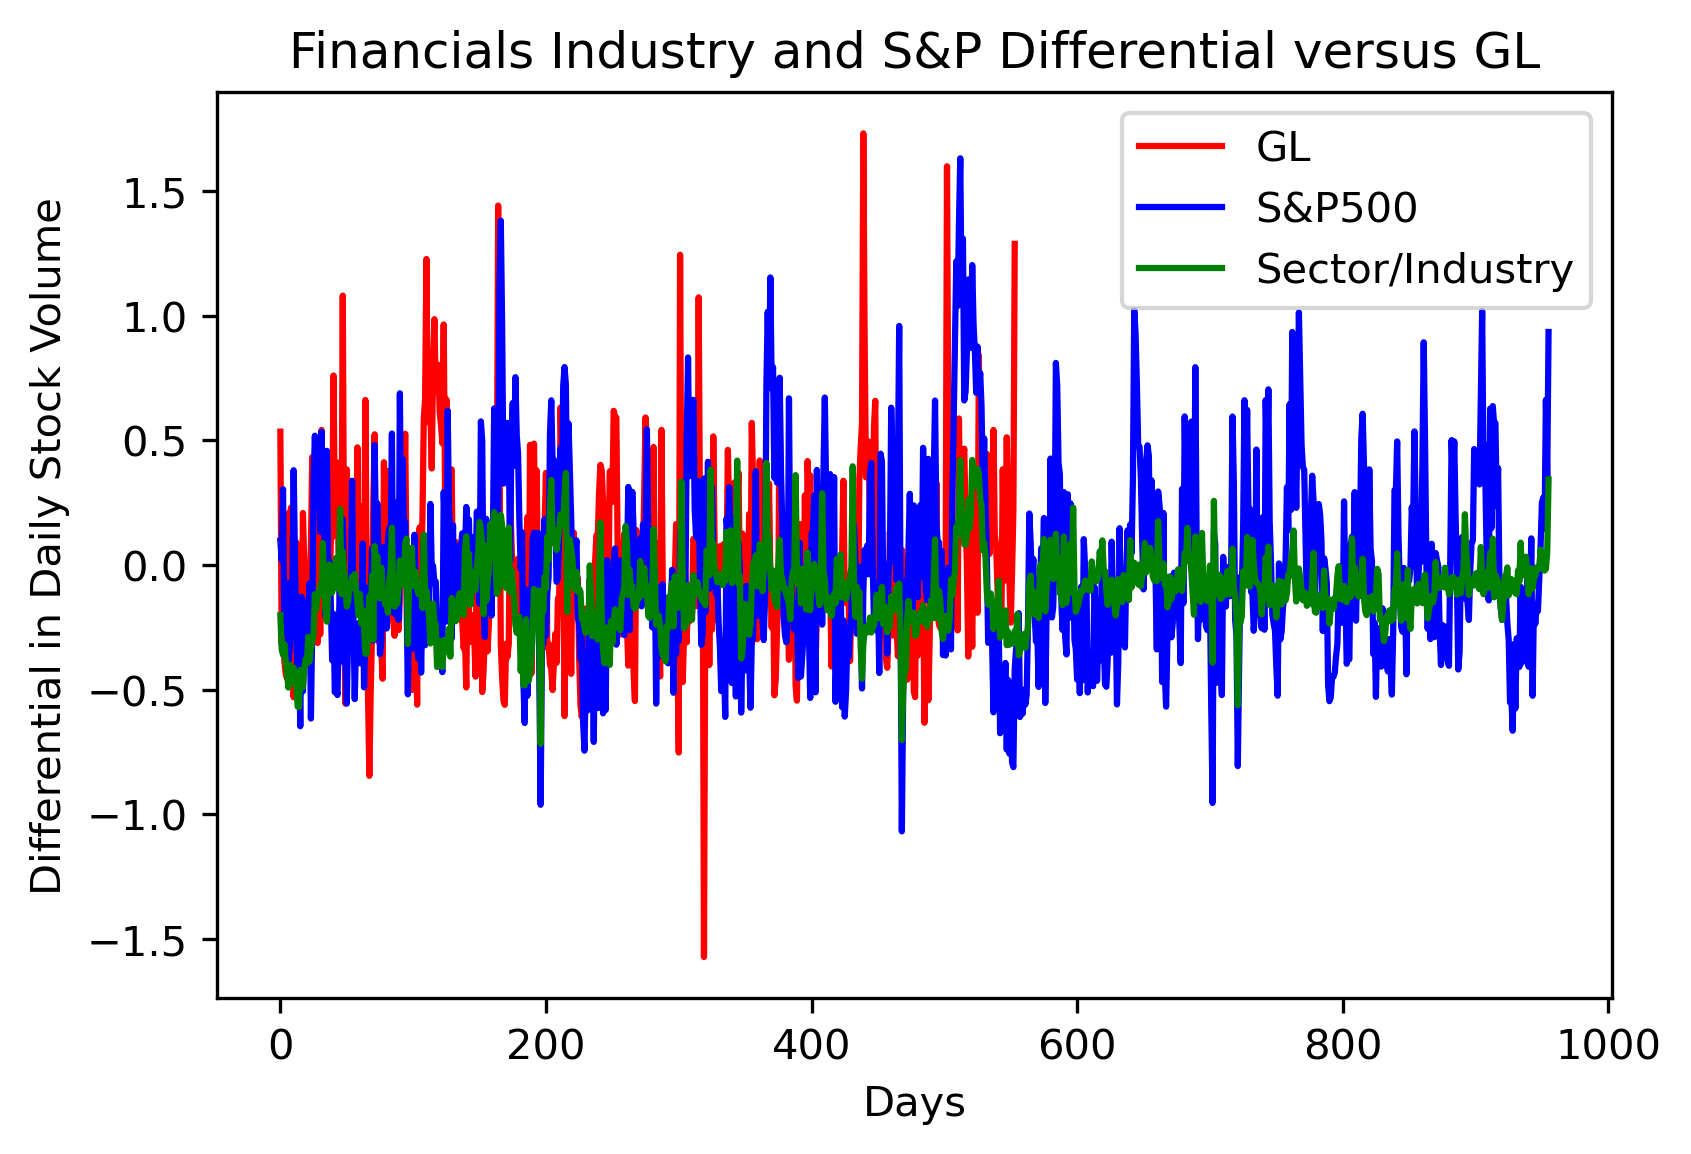

In [269]:
Sector_Regression_Weighted("Financials", "GL")

In [264]:
# Perform weighted regression on differentials of the stock versus the SPY control and the Sector
def Sector_Regression_Weighted(Input1, Input2):
    HC = alty.loc[alty.Sector == Input1].sort_index()
    tot = len(HC.symbol.unique())
    weighted = pd.Series([])
    for sym in HC.symbol.unique():
        cur = sp.loc[sp.symbol == sym].reset_index().log_vol
        weighted = weighted.add(cur,fill_value=0)
    weighted = weighted/tot
    frame = weighted.to_frame()
    frame = frame.rename(columns = {frame.columns[0]: 'Tot'})
    frame['dTot'] = frame.Tot - frame.Tot.rolling(30).mean()
    frame = frame[pd.notnull(frame.dTot)].reset_index(drop =True)
    d = frame.dTot
    dOut = alty.loc[alty.symbol == Input2].reset_index().perc_dif
    model = pd.concat([dOut,ctrl,d],axis=1)
    model = model.rename(columns = {model.columns[0]: 'Out', model.columns[1]: 'SPY'})
    result = smf.ols(formula = "Out ~ SPY + dTot",data = model).fit()
    print(result.summary())
    print(np.corrcoef(model.Out,model.dTot))
    plt.plot(model.Out,color='red', label=Input2)
    plt.plot(model.SPY,color='blue', label='S&P500')
    plt.plot(model.dTot,color='green', label='Sector/Industry')
    plt.legend()
    plt.title(Input1 + " Industry and S&P Differential versus " + Input2)
    plt.xlabel("Days")
    plt.ylabel("Differential in Daily Stock Volume")
    plt.show()
    return result

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_16711/1913461796.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  weighted = pd.Series([])


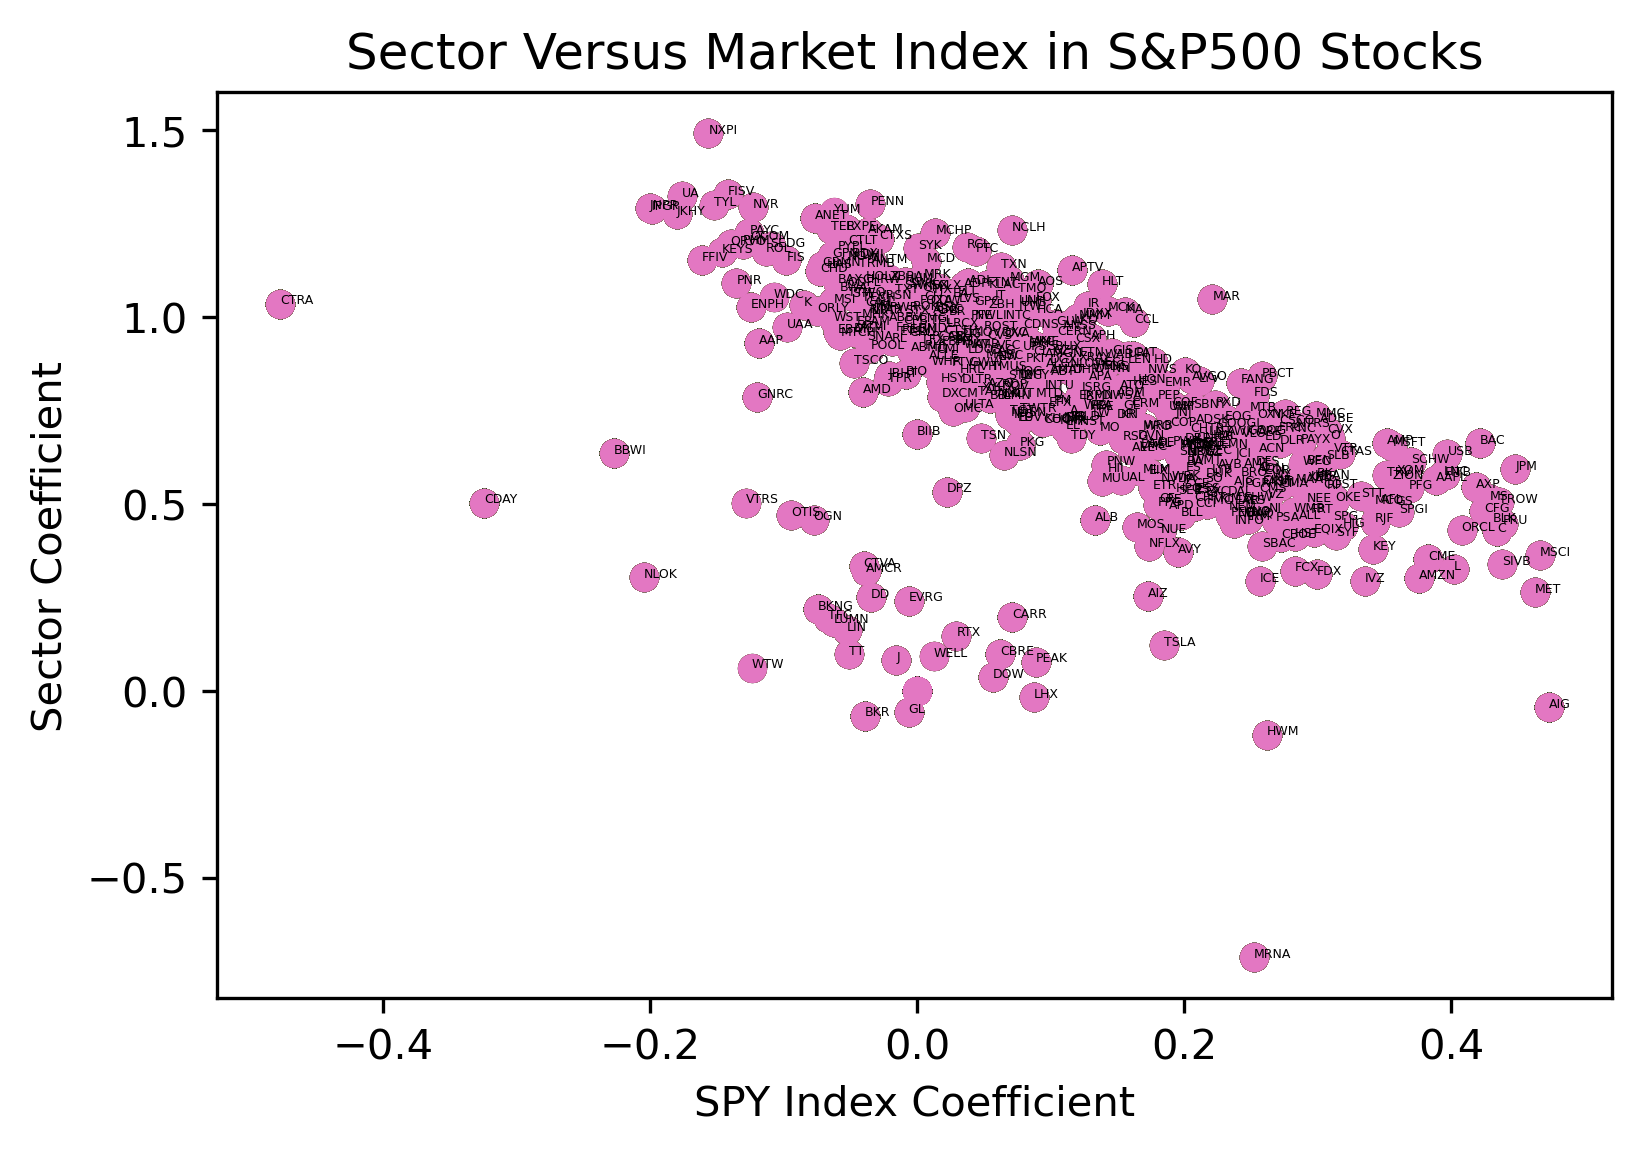

In [252]:
# Produce dataframe, lis, with all of the regressions for each stock
# Scatter plot the SPY coefficient versus the sector coefficient
arr = alty.symbol.unique()
lis = use.reset_index()
lis
lis['SPY_Term_Weighted'] = 0
lis['Industry_Term_Weighted'] = 0
lis['SPY_Term_Unweighted'] = 0
lis['Industry_Term_Unweighted'] = 0
for i in range(504):    
    symb = lis.Symbol[i]
    sect = lis.Sector[i]
    if symb in arr:
        reg_w = Sector_Regression_Weighted(sect,symb)
        coef_w = reg_w.params
        lis.loc[lis.index == i, 'SPY_Term_Weighted'] = coef_w[1]
        lis.loc[lis.index == i, 'Industry_Term_Weighted'] = coef_w[2]
        plt.scatter(lis.SPY_Term_Weighted, lis.Industry_Term_Weighted)
        plt.annotate(symb,(coef_w[1],coef_w[2]),fontsize=3)
    else:
        x = 1
plt.xlabel('SPY Index Coefficient')
plt.ylabel('Sector Coefficient')
plt.title('Sector Versus Market Index in S&P500 Stocks')
plt.savefig('ScatterPl.png', dpi=300)
plt.show()

In [217]:
# def Sector_Regression_Lag(Sect, Stck):
#     Sector = alty.loc[alty.Sector == Sect].sort_index()
#     tot = len(Sector.symbol.unique())
#     weighted = pd.Series([])
#     for sym in HC.symbol.unique():
#         cur = sp.loc[sp.symbol == sym].reset_index().log_vol
#         weighted = weighted.add(cur,fill_value=0)
#     weighted = weighted/tot
#     frame = weighted.to_frame()
#     frame = frame.rename(columns = {frame.columns[0]: 'Tot'})
#     frame['dTot'] = frame.Tot - frame.Tot.rolling(30).mean()
#     frame = frame[pd.notnull(frame.dTot)].reset_index(drop =True)
#     d = frame.dTot
#     dOut = alty.loc[alty.symbol == Input2].reset_index().perc_dif
#     model = pd.concat([dOut,ctrl,d],axis=1)
#     model = model.rename(columns = {model.columns[0]: 'Out', model.columns[1]: 'SPY'})
#     result = smf.ols(formula = "Out ~ SPY + dTot",data = model).fit()
#     print(result.summary())
#     print(np.corrcoef(model.Out,model.dTot))
#     plt.plot(model.Out,color='red', label=Input2)
#     plt.plot(model.SPY,color='blue', label='S&P500')
#     plt.plot(model.dTot,color='green', label='Sector/Industry')
#     plt.legend()
#     plt.title(Input1 + " Industry and S&P Differential versus " + Input2)
#     plt.xlabel("Days")
#     plt.ylabel("Differential in Daily Stock Volume")
#     plt.show()
#     return result

121